# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [19]:
# Import stuff.
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import ast

In [7]:
pip install ast

  Using cached AST-0.0.2.tar.gz (19 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [21 lines of output]
  Traceback (most recent call last):
    File "C:\Users\kabir\.vscode\Code Files\2024-DS-Wed\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\kabir\.vscode\Code Files\2024-DS-Wed\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\kabir\.vscode\Code Files\2024-DS-Wed\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
      return hook(config_settings)
             ^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\kabir\AppData\Local\Temp\pip-build-env-3rarf9z7\overlay\Lib\site-packages\setuptools\build_meta.py", l

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [66]:
rules_data_path = r'data/rules.tsv.xz'

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,
                       converters={
                           'consequent_item': ast.literal_eval,
                           'antecedent_items': ast.literal_eval
                       },
                       low_memory=True)

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [67]:
# Show the list of column names and the number of rules.

df_rules.shape

(1048575, 6)

## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [88]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.
df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']
df_rules['lift'] = df_rules['confidence'] / (df_rules['consequent_count'] / df_rules['transaction_count'])
print(df_rules.columns)
df_rules


Index(['consequent_item', 'transaction_count', 'item_set_count',
       'antecedent_count', 'consequent_count', 'antecedent_items', 'support',
       'confidence', 'lift'],
      dtype='object')


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
...,...,...,...,...,...,...,...,...,...
1048570,Apples and Plums Stage 2 Baby Food,3346083,190,3346083,190,[],0.000057,0.000057,1.000000
1048571,Apitherapy Raw Honey,3346083,190,3346083,190,[],0.000057,0.000057,1.000000
1048572,Antioxidant Super Tea Pomegranate Peach Passio...,3346083,190,3346083,190,[],0.000057,0.000057,1.000000
1048573,All Natural Sausage Fully Cooked - 6 CT,3346083,190,3346083,190,[],0.000057,0.000057,1.000000


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

If we assume the probabilities we are dealing with is the probability the item enters the cart, then we can come to the inference that when a user buys a yogurt, they are very likely to buy another item (concedent)

# Query the rule set if you have to to find out more.
If we assume the probabilities we are dealing with is the probability the item enters the cart, then we can come to the inference that if a user buys a yogurt, then are very likely to buy another item (the concedent)


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [112]:
# Define df_rules_subset.
df_rules_subset = df_rules[(df_rules['antecedent_items'].apply(len) == 1)
                & (df_rules['lift'] > 5) & (df_rules['lift'] < 20)
                & (
                df_rules['antecedent_items'].apply(lambda x: 'Hummus' in x) ^  # XOR for exact match in antecedents
                df_rules['consequent_item'].apply(lambda x: 'Hummus' in x))  # XOR for exact match in consequents
                ]
#weird workaround to join 
df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(lambda x: ', '.join(x))

#replace any with hummus to just hummus
df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].str.replace(r'.*Hummus.*', 'Hummus', regex=True)
df_rules_subset['consequent_item'] = df_rules_subset['consequent_item'].str.replace(r'.*Hummus.*', 'Hummus', regex=True)

print(df_rules_subset)




       consequent_item  transaction_count  item_set_count  antecedent_count  \
416420          Hummus            3346083             345              1656   
419119          Hummus            3346083             293              1434   
422178          Hummus            3346083             331              1655   
440198          Hummus            3346083            3119             17333   
463035          Hummus            3346083             151               933   
463988          Hummus            3346083             311              1929   
476420          Hummus            3346083             512              3333   
506520          Hummus            3346083             168              1208   
519416          Hummus            3346083             117               875   
523791          Hummus            3346083            1544             11702   
531448          Hummus            3346083             166              1287   
546619          Hummus            3346083           

C:\Users\kabir\AppData\Local\Temp\ipykernel_2612\1703949439.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(lambda x: ', '.join(x))
C:\Users\kabir\AppData\Local\Temp\ipykernel_2612\1703949439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].str.replace(r'.*Hummus.*', 'Hummus', regex=True)
C:\Users\kabir\AppData\Local\Temp\ipykernel_2612\1703949439.

Build a network `graph_rules_subset` from the association rules subset.

C:\Users\kabir\AppData\Local\Temp\ipykernel_2612\3725590732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].astype(str)


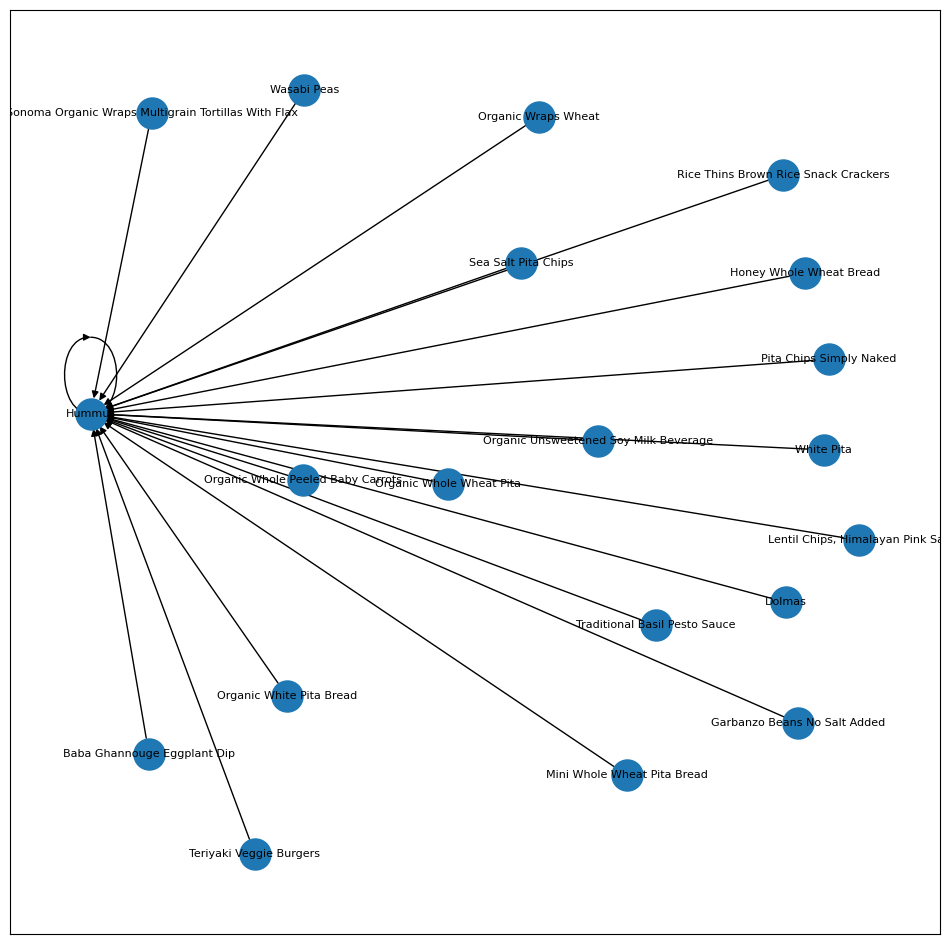

In [114]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.
df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].astype(str)

graph_rules_subset = nx.MultiDiGraph()
graph_rules_subset.add_edges_from(
    # Something goes here.
    (row['antecedent_items'], row['consequent_item'], {'lift': row['lift']})
    for _, row in df_rules_subset.iterrows()
)

# Then render the graph.
plt.figure(figsize=(12, 12))
nx.draw_networkx(graph_rules_subset, with_labels=True, node_size=500, font_size=8)


What can you tell about people who buy hummus?

when they buy one hummus, they are very likely to buy another. 

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [116]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}
#lambda function to find basket items as antecedents
df_rules_subset = df_rules[
    df_rules['antecedent_items'].apply(lambda x: any(item in x for item in basket))
]

# Sort by lift in descending order and get the top 20 predictions
top_20_predictions = df_rules_subset.sort_values('lift', ascending=False).head(20)
print(top_20_predictions)

                                          consequent_item  transaction_count  \
342462      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
345882      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
346832           Nonfat Icelandic Style Strawberry Yogurt            3346083   
346901                           Non Fat Raspberry Yogurt            3346083   
349532      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
350852      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
350991                           Non Fat Raspberry Yogurt            3346083   
351360      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
351433           Nonfat Icelandic Style Strawberry Yogurt            3346083   
351881      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
352283                         Vanilla Skyr Nonfat Yogurt            3346083   
352884                        Organic Fr

## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.